# Simple RNN

In this notebook, we're going to train a simple RNN to do **time-series prediction**. Given some set of input data, it should be able to generate a prediction for the next time step!
<img src='assets/time_prediction.png' width=40% />

> * First, we'll create our data
* Then, define an RNN in PyTorch
* Finally, we'll train our network and see how it performs

### Import resources and create data 

In [125]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

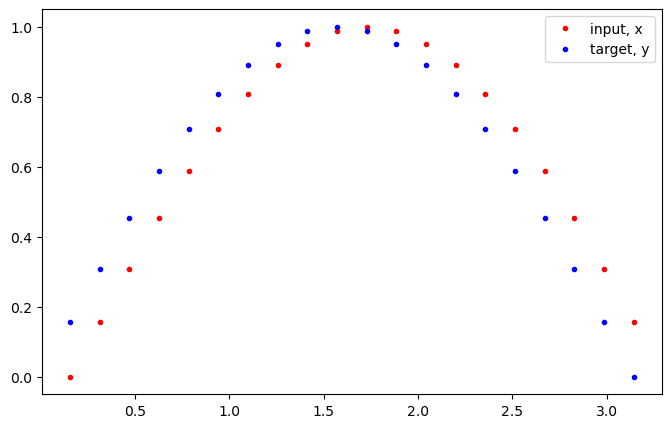

In [126]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

---
## Define the RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

Take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn) to read more about recurrent layers.

In [127]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden


### Check the input and output dimensions

As a check that your model is working as expected, test out how it responds to input data.

In [128]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


---
## Training the RNN

Next, we'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps, and see how it performs.

In [129]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Loss and Optimization

This is a regression problem: can we train an RNN to accurately predict the next data point, given a current data point?

>* The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error.
* It's typical to use an Adam optimizer for recurrent models.

In [130]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

### Defining the training function

This function takes in an rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions, every so often.

#### Hidden State

Pay close attention to the hidden state, here:
* Before looping over a batch of training data, the hidden state is initialized
* After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the following steps

In [131]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i % print_every == 0:
            print('Step: ', step, ' Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn


Step:  0  Loss:  0.5774663686752319


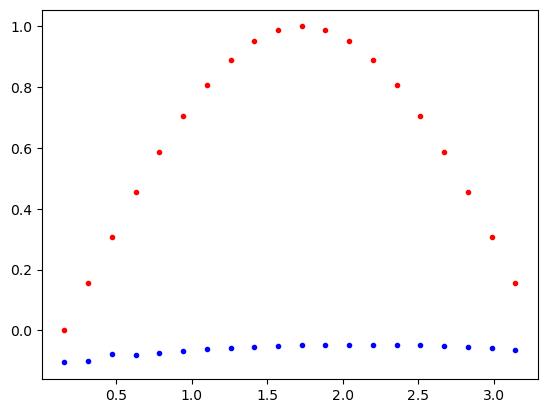

Step:  15  Loss:  0.02566761150956154


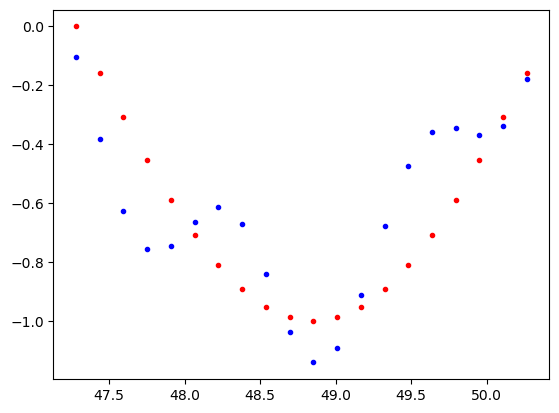

Step:  30  Loss:  0.001965594943612814


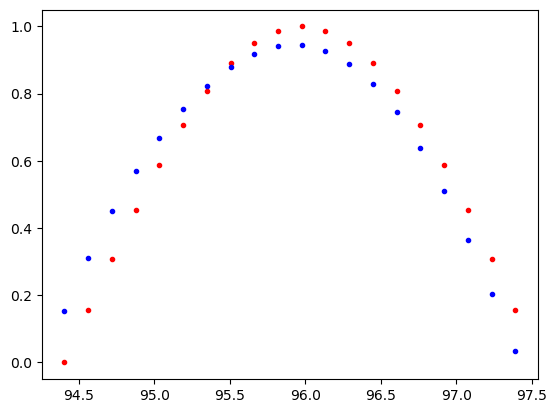

Step:  45  Loss:  0.0008906389703042805


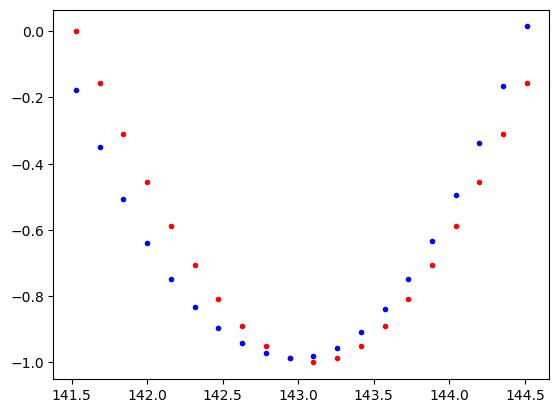

Step:  60  Loss:  0.0007476716418750584


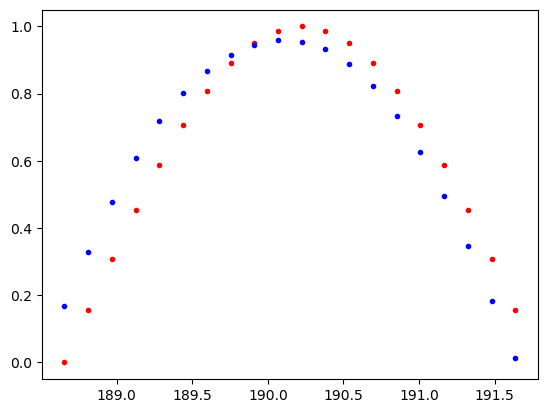

Step:  75  Loss:  0.00035902534727938473


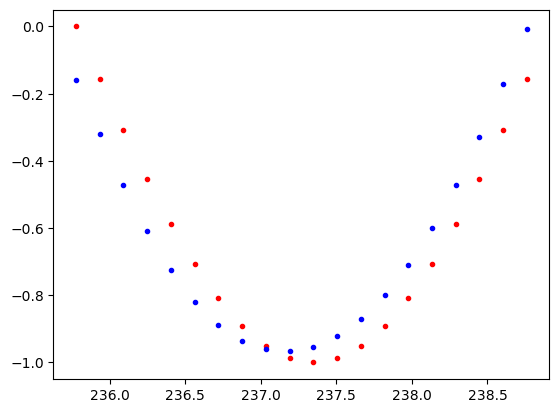

Step:  90  Loss:  0.00014570719213224947


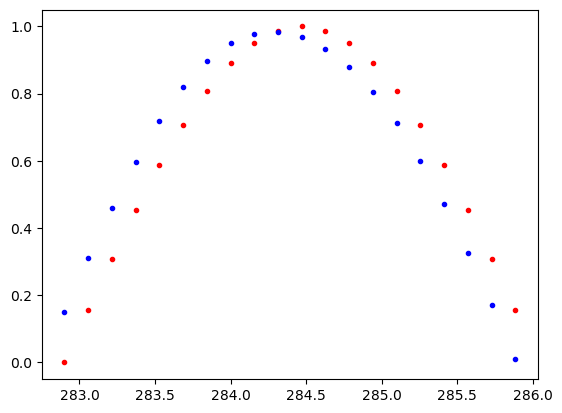

Step:  105  Loss:  5.2210625653970055e-06


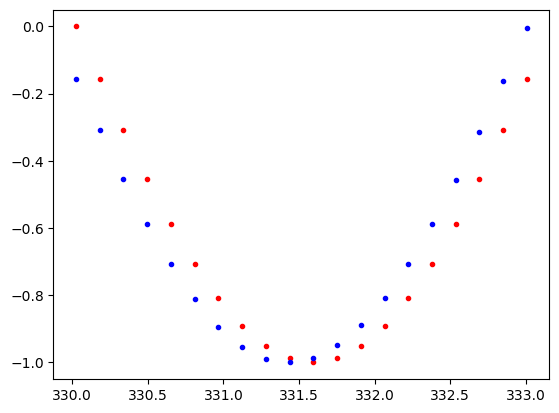

Step:  120  Loss:  1.6418964605691144e-06


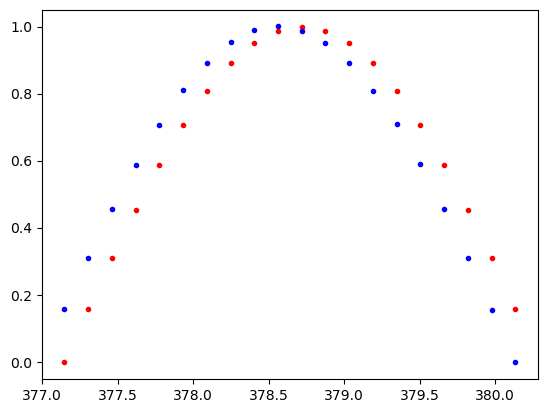

Step:  135  Loss:  3.9160499909485225e-06


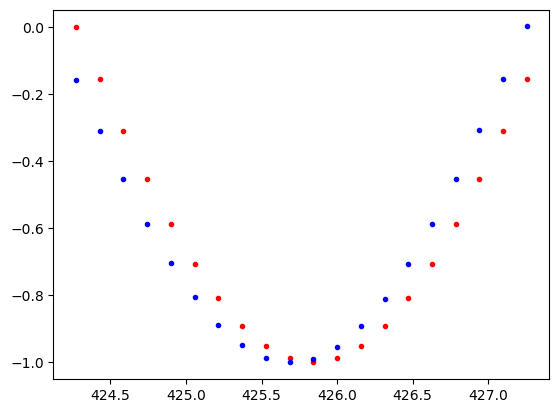

Step:  150  Loss:  1.3620635854749708e-06


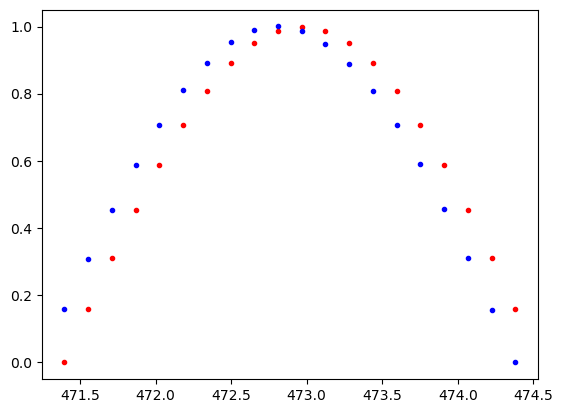

Step:  165  Loss:  1.2092244787709205e-06


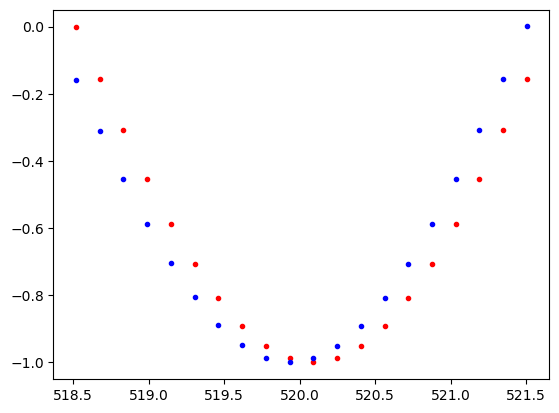

In [132]:
# train the rnn and monitor results
n_steps = 175 # Changed by Edgarin. It was 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

### Time-Series Prediction

Time-series prediction can be applied to many tasks. Think about weather forecasting or predicting the ebb and flow of stock market prices. You can even try to generate predictions much further in the future than just one time step!

El resto q queda son mis experimentos

In [176]:
test_seq_length = 50
start_test_step = 1000
# test_steps = np.linspace(0, np.pi, test_seq_length)
test_steps = np.linspace(start_test_step * np.pi, (start_test_step+1)*np.pi, test_seq_length)
test_x = np.sin(test_steps)
test_x.resize((test_seq_length, 1))

test_x = torch.Tensor(test_x).unsqueeze(0) # give it a batch_size of 1 as first dimension

In [177]:
pred, hidden = trained_rnn.forward(test_x, None)

In [178]:
import pandas as pd
df = pd.DataFrame(data={'x': test_x[0,:,0], 'y': pred[:,0].detach().numpy()})
df

,x,y
0,-3.214166e-13,0.006674
1,6.407022e-02,0.145697
2,1.278772e-01,0.183060
3,1.911586e-01,0.181109
4,2.536546e-01,0.250816
5,3.151082e-01,0.354332
6,3.752670e-01,0.416821
7,4.338837e-01,0.438442
8,4.907176e-01,0.467775
9,5.455349e-01,0.521449


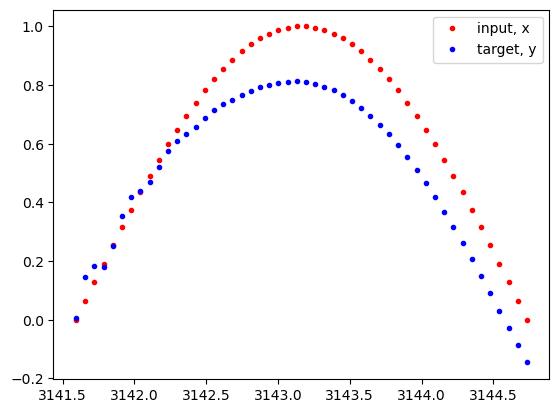

In [179]:
plt.plot(test_steps, test_x.data.numpy().flatten(), 'r.', label='input, x') # input
plt.plot(test_steps, pred.data.numpy().flatten(), 'b.', label='target, y') # predictions
plt.legend(loc='best')
plt.show()

<AxesSubplot: xlabel='x', ylabel='y'>

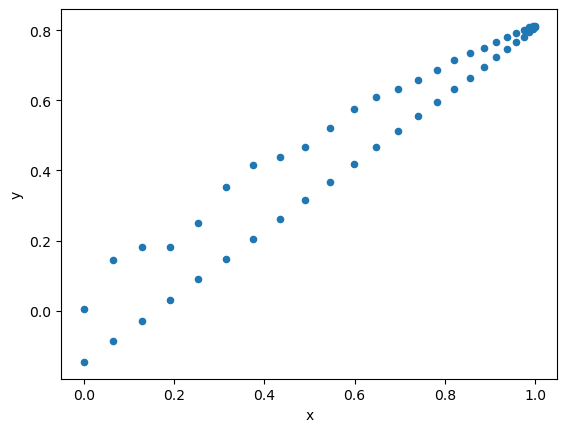

In [180]:
df.plot(kind='scatter', x='x', y='y')